# Rating Predictions (Development)
*Author: Koki Sasagawa*  
*Date: 10/8/2018* 

## Task
Build a recommendation system that predicts a rating on the scale of 1 to 5 for a given user product. Collaborative filtering models are based on the idea that people tend to like things that are similar to other things they like, and things that are liked by other people that share similar preferences. 

2 approaches: 
- Memory based approach cosine similarity and weighted averages of ratings
- Model based approach using SVD for matrix factorization

## Running the notebook
This notebook requires `predictions.py`, `evaluations.py`, and `decorators.py` files

In [65]:
import os
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, SlopeOne, Dataset, Reader
from surprise.model_selection import GridSearchCV, cross_validate

from predictions import baseline, collaborative_filter_predictions
from evaluations import rmse_test
from decorators import timer 

%matplotlib inline

## 1. Load files

In [2]:
dev_df = pd.read_csv('../temp_data/dev_set.dev.csv')
print('Number of rows: {}'.format(dev_df.shape[0]))
dev_df.head()

Number of rows: 169724


,reviewerID,asin,overall
0,A34DNO6UAH67Z0,B000CDSS22,5
1,A3APW42N5MRVWT,6305186774,2
2,A20D9VGCF3P13L,B004LWZW24,5
3,A82LIVYSX6WZ9,B00001U0DM,3
4,A3LRKDF5WU4ZDO,B00005JOZI,3


In [3]:
train_df = pd.read_csv('../temp_data/train_set.dev.csv', index_col=False)
print('Number of rows: {}'.format(train_df.shape[0]))
train_df.head()

Number of rows: 1358026


,reviewerID,asin,overall
0,AMFIPCYDYWGVT,B0090SI56Y,4
1,A3G602Z4DWDZKS,B00005JL99,5
2,A33BOYMVG3U58Y,B00109KN0M,5
3,ANEDXRFDZDL18,B00005JMPT,5
4,A1VN7IS16PY024,B00005AAA9,4


In [4]:
train_matrix = sparse.load_npz('../temp_data/movie_reviews.dev.npz')
print('Sparse matrix dimensions: {}'.format(train_matrix.shape))
print('Number of stored values: {}'.format(train_matrix.nnz))

# Covert to sparse row format 
train_matrix = train_matrix.tocsr()
print('Matrix type: {}'.format((type(train_matrix))))

Sparse matrix dimensions: (50050, 123952)
Number of stored values: 1358026
Matrix type: <class 'scipy.sparse.csr.csr_matrix'>


In [5]:
with open('../temp_data/movie_index_map.dev.p', 'rb') as fp:
    row_index_to_movies = pickle.load(fp)
    
print('Number of row indexes: {}'.format(len(row_index_to_movies)))

Number of row indexes: 50050


In [6]:
with open('../temp_data/reviewer_index_map.dev.p', 'rb') as fp:
    col_index_to_reviewer = pickle.load(fp)
    
print('Number of col indexes: {}'.format(len(col_index_to_reviewer)))

Number of col indexes: 123952


## 2. Baseline Predictions

baseline prediction calculated using the following equation:

$r = u + b_x + b_i$

Where:  
$u$ = overall mean rating  
$b_x$ = rating deviation of reviewer (ave rating of reviewer - u)  
$b_i$ = rating deviation of movie (ave rating of movie - u)

In [27]:
predictions = []

for i in dev_df.itertuples():
    reviewer = i[1]
    movie = i[2]

    # Retrieve index of reviewer and movie 
    reviewer = col_index_to_reviewer.get(reviewer, False)
    movie = row_index_to_movies.get(movie, False)

    # Make prediction if reviewer and movie exist in training set
    if reviewer and movie: 
        predictions.append(baseline(r_idx=reviewer, m_idx=movie, sparse_matrix=train_matrix))
    else:
        predictions.append(0)

In [29]:
# Save predictions 
baseline_predictions = pd.DataFrame({'reviewer': dev_df['reviewerID'],
                                     'movie': dev_df['asin'],
                                     'predicted_values': predictions})

baseline_predictions.to_csv('../output/baseline_predictions.dev.csv', index=False)

In [30]:
baseline_predictions.head()

,reviewer,movie,predicted_values
0,A34DNO6UAH67Z0,B000CDSS22,5.541179
1,A3APW42N5MRVWT,6305186774,3.703254
2,A20D9VGCF3P13L,B004LWZW24,4.115846
3,A82LIVYSX6WZ9,B00001U0DM,1.494133
4,A3LRKDF5WU4ZDO,B00005JOZI,4.529005


In [31]:
baseline_rmse = rmse_test(predicted_data=baseline_predictions['predicted_values'], true_data=dev_df['overall'])
print('Baseline RMSE Score: {:.5f}'.format(baseline_rmse))

Baseline RMSE Score: 1.07407


## 2. Memory based approach via Cosine Similarity

### 2.a. Get cosine similarity scores of movies

In [7]:
# Cosine similarity of movies
sim_scores = cosine_similarity(train_matrix, dense_output=False)
print('Matrix shape: {}'.format(sim_scores.shape))

Matrix shape: (50050, 50050)


### 2.b. Plot distribution of similarity scores 

/Users/koki/Documents/Learning/UMICH_course_material/SI_671_Data_Mining/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


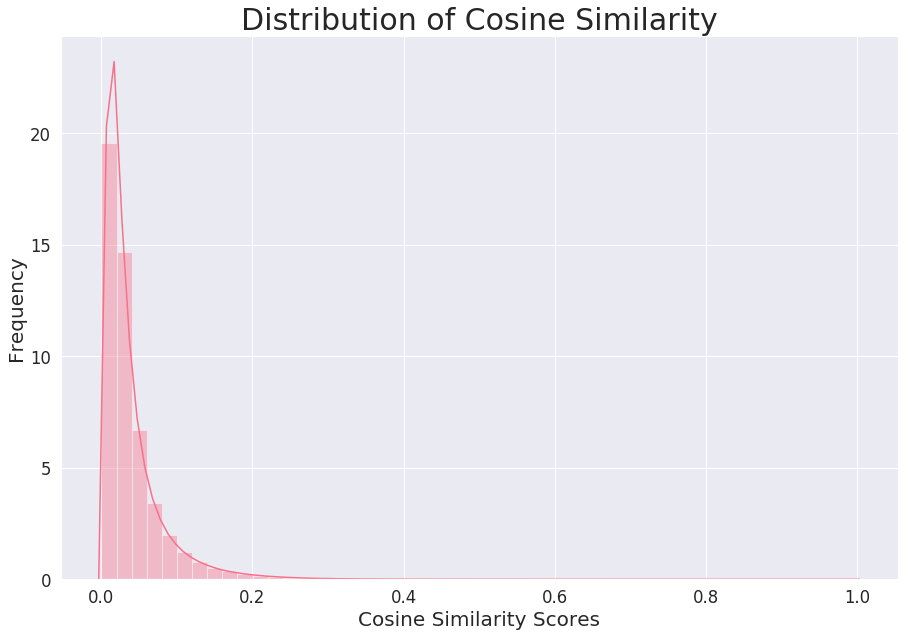

In [9]:
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,10))

# Create plot
g = sns.distplot(sim_scores.data)

# Add plot labels 
g.set_xlabel('Cosine Similarity Scores', fontsize=20)
g.set_ylabel('Frequency', fontsize=20)
g.axes.set_title('Distribution of Cosine Similarity', fontsize=30)

# Save File
fig = g.get_figure()
fig.savefig('../images/{}.png'.format('distribution_of_cosine_similarity'))

The distribution of cosine similarity scores is very right skewed. Most movies have very low similarity scores below 0.2. Due to low similarity scores, using the ratings given to movies with low similarity scores to estimate the ratings of our target movie many not be as accurate.

### 2.c. Make predictions

In [8]:
# Add timer decorator to measure runtime
collaborative_filter_predictions = timer(collaborative_filter_predictions)

In [9]:
# Generate CF predictions at varying thresholds 
threshold = [0.1, 0.15, 0.2, 0.25, 0.3]

true_ratings = dev_df['overall'].tolist()

rmse_scores = []

for i in threshold:
    print('Threshold: {}'.format(i))
    predictions = collaborative_filter_predictions(data=dev_df,
                                                   col_idx_map=col_index_to_reviewer,
                                                   row_idx_map=row_index_to_movies,
                                                   cos_sim=sim_scores,
                                                   sparse_matrix=train_matrix,
                                                   threshold=i)
    
    rmse = rmse_test(predicted_data=predictions, true_data=dev_df['overall'].tolist())
    print('RMSE: {}'.format(rmse))
    rmse_scores.append(rmse)

Threshold: 0.1
Running collaborative_filter_predictions...
Finished in 1176.2207s
RMSE: 1.1060193002937566
Threshold: 0.15
Running collaborative_filter_predictions...
Finished in 1073.0926s
RMSE: 1.086892983853646
Threshold: 0.2
Running collaborative_filter_predictions...
Finished in 1046.7206s
RMSE: 1.078851696365575
Threshold: 0.25
Running collaborative_filter_predictions...
Finished in 1125.4014s
RMSE: 1.0761124794899433
Threshold: 0.3
Running collaborative_filter_predictions...
Finished in 1331.9301s
RMSE: 1.0749122667817925


The higher the threshold, the better the RMSE score becomes. However, it is important to recognize that higher threshold acts as a stricter filter.  Collaborative filtering takes other movies that a reviewer has rated with varying 'similarity' scores, and uses those ratings to predict a rating for a target movie. A high threshold will filter out movies with lower similarity scores, resulting in fewer movies to use for making a rating prediction. For some movies, a threshold of 0.3 may be enough to remove all movies. For these cases, we calculate the rating using the baseline algorithm instead.

As we increase the threshold, the more predictions will be replaced by baseline predictions. Due to the inherent sparisty of movie-review data, collaborative filtering may not be an effective method for accurately predicting ratings. 

## 3. Model based approach using SVD for matrix factorization

### 3.a. Gridsearch to find optimal parameters

General equation: $\hat{r}_{ui} = q^T_ip_u$

Where:  
$q_i$ = vector representing movie  
$p_u$ = vector representing user

1. Find $q_i$ and $p_u$ such that square error difference with known rating is minimum
> $\text{minimum}(p,q) \sum \limits_{(u,i) \in K}(r_{ui} - q_i^T \cdot p_u)^2$
2. Regularization to introduce penalty term to make model more generalizeable and not over-fit the data.
> $\text{minimum}(p,q) \sum \limits_{(u,i) \in K}(r_{ui} - q_i^T \cdot p_u)^2 + \lambda(||q_i||^2 + ||p_u||^2)$  
> Where:  
> $\lambda$ = regularization factor  
> $(||q_i||^2 + ||p_u||^2)$ = squared sum of magnitude to reviewer and movie vector
3. Bias terms to make use of characteristics of reviewers and movies
> $\hat{r}_{ui} = q^T_ip_u + \mu + b_i + b_u$  
> $\text{minimum}(p,q,b_i,b_u) \sum \limits_{(u,i) \in K}(r_{ui} - q_i^T \cdot p_u - \mu - b_i - b_u)^2 + \lambda(||q_i||^2 + ||p_u||^2 + b_i^2 + b_u^2)$  
> Where:  
> $\mu$ = average ratings of all items  
> $b_i$ = rating deviation of movie (ave rating of movie - $\mu$)  
> $b_u$ = rating deviation of reviewer (ave rating of review - $\mu$)

** Note: The following code block takes a while to run...

In [7]:
# Create Reader to tell SVD what the lower and upper bound of our ratings are
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_df, reader)

param_grid = {'n_factors': [5, 10, 20, 40],
              'n_epochs': [80, 90, 100], 
              'lr_all': [0.001, 0.003, 0.005],
              'reg_all': [0.05, 0.1, 0.15, 0.20]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0153166312058857
{'n_factors': 5, 'n_epochs': 80, 'lr_all': 0.003, 'reg_all': 0.15}


### 3.b. Assess performance with 5 fold cross calidation

In [8]:
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0069  1.0085  1.0069  1.0075  1.0111  1.0082  0.0016  
Fit time          91.93   101.80  111.24  113.55  103.50  104.40  7.66    
Test time         2.95    3.91    3.28    3.69    4.06    3.58    0.41    


{'test_rmse': array([1.00690214, 1.00850411, 1.00694233, 1.00752793, 1.01113902]),
 'fit_time': (91.92945718765259,
  101.79539823532104,
  111.23616003990173,
  113.55128884315491,
  103.5000991821289),
 'test_time': (2.9548580646514893,
  3.906567096710205,
  3.284013271331787,
  3.691129207611084,
  4.063957929611206)}

### 3.c. Fit model with optimal parameters and make predictions 

In [7]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_df, reader)

In [9]:
# Prepare data 
train_data = data.build_full_trainset()

# Fit SVD model with best performing parameters 
model = SVD(n_factors=5, n_epochs=80, lr_all=0.003, reg_all=0.15)
model.fit(train_data)

# Save model
with open('../output/SVD_model.dev.p', 'wb') as fp:
    pickle.dump(model, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
predictions = []

for i in dev_df.itertuples():
    reviewer = i[1]
    movie = i[2]    

    predictions.append(model.predict(reviewer, movie).est)

In [11]:
# Save predictions 
SVD_ratings = pd.DataFrame({'reviewer': dev_df['reviewerID'],
                            'movie': dev_df['asin'],
                            'predicted_values': predictions})

SVD_ratings.to_csv('../output/SVD_predictions.dev.csv', index=False)

In [12]:
SVD_ratings.head()

,reviewer,movie,predicted_values
0,A34DNO6UAH67Z0,B000CDSS22,4.717736
1,A3APW42N5MRVWT,6305186774,3.772784
2,A20D9VGCF3P13L,B004LWZW24,4.209164
3,A82LIVYSX6WZ9,B00001U0DM,2.609192
4,A3LRKDF5WU4ZDO,B00005JOZI,4.581898


In [67]:
SVD_rmse = rmse_test(predicted_data=SVD_ratings['predicted_values'], true_data=dev_df['overall'])
print('SVD RMSE Score: {:.5f}'.format(SVD_rmse))

SVD RMSE Score: 1.00070


## 4. SlopeOne 

Rating calculated using the following equation:

$\hat{r}_{ui} = \mu_u + \frac{1}{|R_i(\mu)|} \sum \limits_{j \in R_i(u)} dev(i,j)$

Where:  
$R_i(u)$ = The set of items $j$ rated by $u$ that also have at least one common user with $i$ 

$dev(i,j)$ = average difference between the ratings of $i$ and $j$

In [30]:
# Fit SlopeOne model
model = SlopeOne()
model.fit(train_data)

# Save Model
with open('../output/SlopeOne_model.dev.p', 'wb') as fp:
    pickle.dump(model, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
predictions = []

for i in dev_df.itertuples():
    reviewer = i[1]
    movie = i[2]

    predictions.append(model.predict(reviewer, movie).est)

In [32]:
# Save predictions 
SlopeOne_ratings = pd.DataFrame({'reviewer': dev_df['reviewerID'],
                                'movie': dev_df['asin'],
                                'predicted_values': predictions})

SlopeOne_ratings.to_csv('../output/SlopeOne_predictions.dev.csv', index=False)

In [33]:
SlopeOne_ratings.head()

,reviewer,movie,predicted_values
0,A34DNO6UAH67Z0,B000CDSS22,5.000000
1,A3APW42N5MRVWT,6305186774,3.567873
2,A20D9VGCF3P13L,B004LWZW24,4.412454
3,A82LIVYSX6WZ9,B00001U0DM,2.019658
4,A3LRKDF5WU4ZDO,B00005JOZI,4.600000


In [46]:
SlopeOne_rmse = rmse_test(predicted_data=SlopeOne_ratings['predicted_values'], true_data=dev_df['overall'])
print('SlopeOne RMSE Score: {:.5f}'.format(SlopeOne_rmse))

SlopeOne RMSE Score: 1.10155


## 5. Average Predictions

Does averaging SlopeOne predictions with SVD improve performance?

In [61]:
combine = SVD_ratings.merge(SlopeOne_ratings, on=['reviewer', 'movie'], how='inner')
print(combine.shape)
combine.head()

(169724, 4)


,reviewer,movie,predicted_values_x,predicted_values_y
0,A34DNO6UAH67Z0,B000CDSS22,4.717736,5.000000
1,A3APW42N5MRVWT,6305186774,3.772784,3.567873
2,A20D9VGCF3P13L,B004LWZW24,4.209164,4.412454
3,A82LIVYSX6WZ9,B00001U0DM,2.609192,2.019658
4,A3LRKDF5WU4ZDO,B00005JOZI,4.581898,4.600000


In [63]:
combine['rating_ave'] = combine[['predicted_values_x', 'predicted_values_y']].mean(axis=1)
combine.head()

,reviewer,movie,predicted_values_x,predicted_values_y,rating_ave
0,A34DNO6UAH67Z0,B000CDSS22,4.717736,5.000000,4.858868
1,A3APW42N5MRVWT,6305186774,3.772784,3.567873,3.670328
2,A20D9VGCF3P13L,B004LWZW24,4.209164,4.412454,4.310809
3,A82LIVYSX6WZ9,B00001U0DM,2.609192,2.019658,2.314425
4,A3LRKDF5WU4ZDO,B00005JOZI,4.581898,4.600000,4.590949


In [64]:
combined_rmse = rmse_test(predicted_data=combine['rating_ave'], true_data=dev_df['overall'])
print('SlopeOne RMSE Score: {:.5f}'.format(combined_rmse))

SlopeOne RMSE Score: 1.02162


Performance did not improve. SVD predictions alone had a better RMSE score. 